In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Diagnosing Hypothyroid disease using Deep Learning**

Hypothyroid disease or Hypothyroidism is one of the most difficult diseases to diagnose. It is a condition which causes your thyroid gland to not produce enough of certain crucial hormones. It usually may not cause noticeable symptoms in the early stages and hence becomes extremely difficult to diagnose. Applying deep learning algorithms can help assist healthcare workers in identifying signs and symptoms based on patterns shown in past cases of patients' data.


In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle # For saving models
import matplotlib.pyplot as plt # For plotting figures
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# For building our model
import keras
from keras.models import Sequential
from keras.layers import Dense

**Data**

The dataset contains the value of different hormone levels of different patients along with our target variable, i.e., if the patient was suffering from hypothyroidism or not.


In [29]:
# Load dataset from csv using pandas
dataset = pd.read_csv('/content/drive/MyDrive/hypothyroid.csv')
dataset.head()

,Unnamed: 0,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72,M,f,f,f,f,f,f,f,f,f,f,f,y,30,y,0.6,y,15,y,1.48,y,10,n,?
1,hypothyroid,15,F,t,f,f,f,f,f,f,f,f,f,f,y,145,y,1.7,y,19,y,1.13,y,17,n,?
2,hypothyroid,24,M,f,f,f,f,f,f,f,f,f,f,f,y,0,y,0.2,y,4,y,1,y,0,n,?
3,hypothyroid,24,F,f,f,f,f,f,f,f,f,f,f,f,y,430,y,0.4,y,6,y,1.04,y,6,n,?
4,hypothyroid,77,M,f,f,f,f,f,f,f,f,f,f,f,y,7.3,y,1.2,y,57,y,1.28,y,44,n,?


**Data Cleaning**



In [30]:
# Renaming the first column as target
dataset = dataset.rename(columns = {dataset.columns[0]:"target"})


In [31]:
# Check the count of data in target
dataset["target"].value_counts()

negative       3012
hypothyroid     151
Name: target, dtype: int64

The value 'hypothyroid' means that the patient was diagnosed with hypothyroidism and ''negative'' means that there hypothyroidism was not diagnosed. We will be mapping the value ''hypothyroid'' as '1' and ''negative'' as '0'.

In [32]:
dataset["target"] = dataset["target"].map({"negative":0,"hypothyroid":1})

In [33]:
print("Unique categories in the column 'pregnant'", dataset['pregnant'].unique())
print("Count of categories in the column 'pregnant' \n", dataset["pregnant"].value_counts())

Unique categories in the column 'pregnant' ['f' 't']
Count of categories in the column 'pregnant' 
 f    3100
t      63
Name: pregnant, dtype: int64


In [34]:
print("Unique categories in the column 'T3 measured'", dataset['T3_measured'].unique())
print("Count of categories in the column 'T3 measured' \n", dataset["T3_measured"].value_counts())

Unique categories in the column 'T3 measured' ['y' 'n']
Count of categories in the column 'T3 measured' 
 y    2468
n     695
Name: T3_measured, dtype: int64


In [35]:
print("Unique categories in the column 'Sex'", dataset['Sex'].unique())
print("Count of categories in the column 'Sex' \n", dataset["Sex"].value_counts())

Unique categories in the column 'Sex' ['M' 'F' '?']
Count of categories in the column 'Sex' 
 F    2182
M     908
?      73
Name: Sex, dtype: int64


In [36]:
# Replacing the categorical values into binary values
dataset = dataset.replace({'f':0,'t':1, 'y':1, 'n':0, 'M':0, 'F':1})
# Displaying the head of the dataset
dataset.head()

,target,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,1,72,0,0,0,0,0,0,0,0,0,0,0,0,1,30,1,0.6,1,15,1,1.48,1,10,0,?
1,1,15,1,1,0,0,0,0,0,0,0,0,0,0,1,145,1,1.7,1,19,1,1.13,1,17,0,?
2,1,24,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.2,1,4,1,1,1,0,0,?
3,1,24,1,0,0,0,0,0,0,0,0,0,0,0,1,430,1,0.4,1,6,1,1.04,1,6,0,?
4,1,77,0,0,0,0,0,0,0,0,0,0,0,0,1,7.3,1,1.2,1,57,1,1.28,1,44,0,?


Some of the features contain '?' values. So we will be replacing them with NaN values to count them.

In [37]:
# Replacing ? into NaN values 
dataset.replace(to_replace='?', inplace=True, value=np.NaN)

Checking for null values


In [38]:
# Count the number of null values
dataset.isnull().sum()

target                          0
Age                           446
Sex                            73
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
thyroid_surgery                 0
query_hypothyroid               0
query_hyperthyroid              0
pregnant                        0
sick                            0
tumor                           0
lithium                         0
goitre                          0
TSH_measured                    0
TSH                           468
T3_measured                     0
T3                            695
TT4_measured                    0
TT4                           249
T4U_measured                    0
T4U                           248
FTI_measured                    0
FTI                           247
TBG_measured                    0
TBG                          2903
dtype: int64

Here, we can see that the feature column "TBG" contains extremely high number of null values. So, we will be not be using this column for our model.

In [39]:
# Dropping the TBG column as it contains extremely high number of null values
dataset.drop('TBG', axis = 1, inplace=True)

In [40]:
# Selecting columns with data type as 'object'
columns = dataset.columns[dataset.dtypes.eq('object')]

# Convert to numeric values
dataset[columns] = dataset[columns].apply(pd.to_numeric, errors='coerce')

**Visualize the patterns or trends in data**

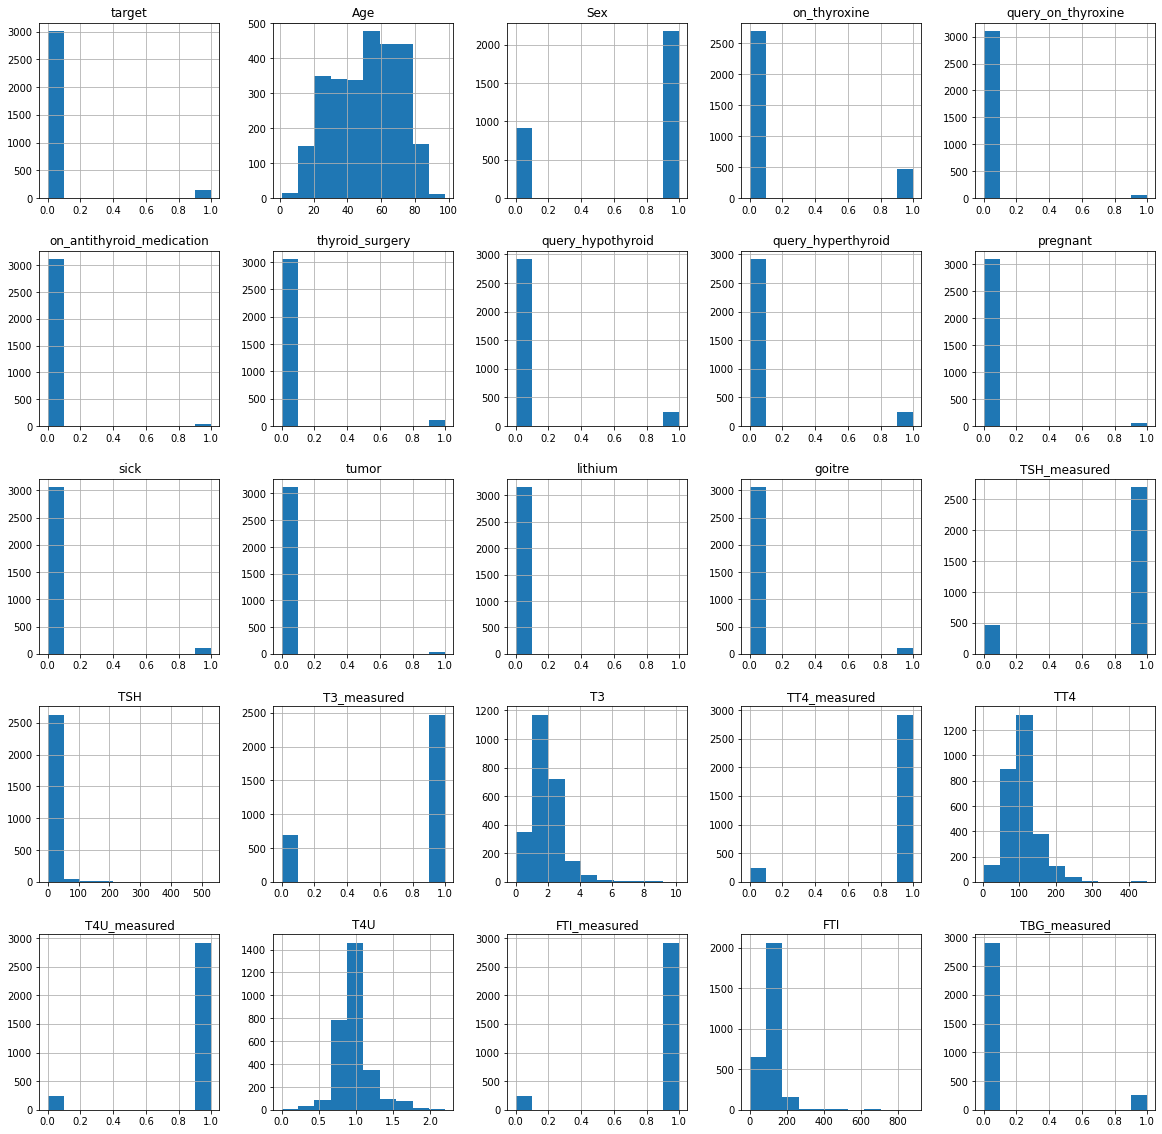

In [41]:
dataset.hist(figsize = (20,20));

**Replacing null values in our data**

In [42]:
# List of columns containing null values
dataset.columns[dataset.isnull().any()].tolist() 

['Age', 'Sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

In [43]:
# Replacing null values by mean 
dataset['Age'].fillna(dataset['Age'].mean(), inplace = True)
dataset['T4U'].fillna(dataset['T4U'].mean(), inplace = True)

# Replacing null values by median
dataset['TSH'].fillna(dataset['TSH'].mean(), inplace = True)
dataset['T3'].fillna(dataset['T3'].median(), inplace = True)
dataset['TT4'].fillna(dataset['TT4'].median(), inplace = True)
dataset['FTI'].fillna(dataset['FTI'].median(), inplace = True)

# The gender data looks to be imbalanced with 0 lesser than 1
# Replacing null values with 0
dataset['Sex'].fillna(0, inplace = True)

**Modeling the data**

We will be using a Neural network for predicting the hypothyroidism (target) based on our input data (features).

In [44]:
# Features
X = dataset.drop('target', axis = 1) # selecting all columns except the target
# Target variable
y = dataset['target']


In [45]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from sklearn.preprocessing import StandardScaler

# Initialization of the class
scaler = StandardScaler()

# Applying the scaler on test and train data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
# Input
model = Sequential()
# Hidden layer
model.add(Dense(64, kernel_initializer='uniform', input_dim=24, activation='relu'))
# Output layer
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
# Training the model
result = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=40,  verbose=2)


Epoch 1/100
51/51 - 1s - loss: 0.5803 - accuracy: 0.9521 - val_loss: 0.4277 - val_accuracy: 0.9625
Epoch 2/100
51/51 - 0s - loss: 0.2917 - accuracy: 0.9555 - val_loss: 0.1714 - val_accuracy: 0.9644
Epoch 3/100
51/51 - 0s - loss: 0.1375 - accuracy: 0.9644 - val_loss: 0.0961 - val_accuracy: 0.9743
Epoch 4/100
51/51 - 0s - loss: 0.0919 - accuracy: 0.9694 - val_loss: 0.0708 - val_accuracy: 0.9842
Epoch 5/100
51/51 - 0s - loss: 0.0723 - accuracy: 0.9768 - val_loss: 0.0589 - val_accuracy: 0.9842
Epoch 6/100
51/51 - 0s - loss: 0.0625 - accuracy: 0.9792 - val_loss: 0.0528 - val_accuracy: 0.9842
Epoch 7/100
51/51 - 0s - loss: 0.0570 - accuracy: 0.9792 - val_loss: 0.0498 - val_accuracy: 0.9842
Epoch 8/100
51/51 - 0s - loss: 0.0535 - accuracy: 0.9802 - val_loss: 0.0478 - val_accuracy: 0.9822
Epoch 9/100
51/51 - 0s - loss: 0.0508 - accuracy: 0.9817 - val_loss: 0.0452 - val_accuracy: 0.9822
Epoch 10/100
51/51 - 0s - loss: 0.0491 - accuracy: 0.9822 - val_loss: 0.0441 - val_accuracy: 0.9802
Epoch 11/

**Accuracy**

In [50]:
# Get the loss and accuracy of the model by evaluation
loss, acc = model.evaluate(X_test, y_test)

# Print the loss and accuracy score for the model
print("%s: %.2f%%" % (model.metrics_names[0], loss*100))
print("%s: %.2f%%" % (model.metrics_names[1], acc*100))

20/20 [==============================] - 0s 977us/step - loss: 0.0643 - accuracy: 0.9826
loss: 6.43%
accuracy: 98.26%


In [51]:
# Predicting the output predictions
y_pred = model.predict(X_test).round()
# Calculating the F1 score, recall, and precision
print("%s: %.2f%%" % ("F1-score", f1_score(y_test, y_pred)*100))
print("%s: %.2f%%" % ("Recall", recall_score(y_test, y_pred)*100))
print("%s: %.2f%%" % ("Precision", precision_score(y_test, y_pred)*100))

F1-score: 84.06%
Recall: 78.38%
Precision: 90.62%


**Training and validation loss**

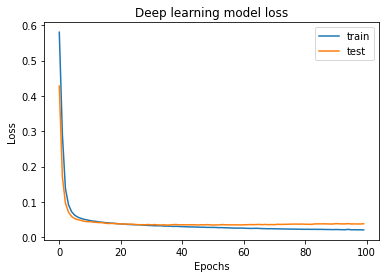

In [52]:
# summarize the result and plot the training and test loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])

# Set the parameters
plt.title('Deep learning model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')

# Display the plots
plt.show()


**Training and validation accuracy**

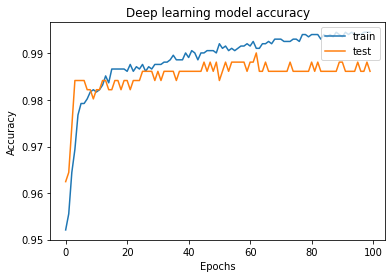

In [53]:
# summarize the result and plot the training and test accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

# Set the parameters
plt.title('Deep learning model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')

# Display the plots
plt.show()

**Conclusion**

In this project, we have illustrated the potential use of neural networks in diagnosing hypothyroid disease. The identification of thyroid disease identiﬁcation remains to be an essential yet difﬁcult task in both clinical diagnosis and statistical classification. The diagnosis involves the use of a large number of interrelated patient attributes along with extremely unbalanced groups that result in a complicated relationship between the input features. However, Artiﬁcial neural networks show a promising result due to its flexible nature in modeling complex patterns of data for diagnosis. This knowledge can be further extended for many other disease diagnosis where such problems exist.